In [1]:
!ls /mnt/processed/private/paturo/Geospatial/preprocessing/processed

0.csv	14.csv	19.csv	23.csv	28.csv	32.csv	37.csv	41.csv	46.csv	5.csv
10.csv	15.csv	1.csv	24.csv	29.csv	33.csv	38.csv	42.csv	47.csv	6.csv
11.csv	16.csv	20.csv	25.csv	2.csv	34.csv	39.csv	43.csv	48.csv	7.csv
12.csv	17.csv	21.csv	26.csv	30.csv	35.csv	3.csv	44.csv	49.csv	8.csv
13.csv	18.csv	22.csv	27.csv	31.csv	36.csv	40.csv	45.csv	4.csv	9.csv


In [2]:
import os
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from glob import glob
from tqdm import tqdm
import geopandas as gpd
import multiprocessing as mp
import rasterio
from rasterio.plot import show
from rasterio.mask import mask

## Visualization of Raster File and Cauayan Boundary

<AxesSubplot:>

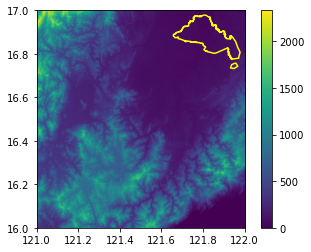

In [3]:
raster_root = './raster_zip/'
src = rasterio.open(raster_root + "N16E121.hgt", driver="SRTMHGT")

# boundaries = gpd.read_file("data/Cauayan QGIS/Cauayan City Boundary.shp")#.to_crs(outProj)
# boundaries.to_pickle('bounds.pkl')
boundaries = pd.read_pickle(raster_root + 'bounds.pkl')
                     
fig, ax = plt.subplots(1)
show(src, ax=ax)
plt.colorbar(ax.images[0])
boundaries.boundary.plot(ax=ax, color='yellow')

In [4]:
def get_value(coords, src):
    """Return elevation from src"""
    
    if type(coords) != list:
        coords = [coords]
    return next(src.sample(coords))[0]

building_types = {
    'pix_business': 1,
    'pix_residential': 2,
    'pix_industrial': 3
}

def get_building_counts(row, src, buffer):
    """Return pixel count of a building class within a buffer"""
    geometry = row.geometry.buffer(buffer) # buffer points by the meters (ensure data is projected)
    out_image, out_transform = mask(src, [geometry], all_touched=True, crop=True)
    for key, val in building_types.items():
        row[key] = np.sum(out_image==val)
    return row

def filter_df(df):
    """Return filtered df"""
    df = df[df['dist_to_edge'] <= 20]
    df = df[df['accel'] <= 20]
    df = df[df['decel'] <= 20]
    df['barangay'] = df['barangay'].fillna('Out-of-town')
    df['lanes'] = df['lanes'].fillna(1.0)
    df = df[df['vehicle_speed'] <= 100]
    df = df[df['altitude'] <= 5000]
    return df

In [5]:
def mp_elevation(gdf_chunk):
    root = './raster_zip/'
    src = rasterio.open(root + "N16E121.hgt", driver="SRTMHGT")
    gdf_chunk['elevation'] = gdf_chunk.apply(lambda row: get_value((row.geometry.x, row.geometry.y), src), axis=1)
    return gdf_chunk

def mp_building_counts(gdf_chunk):
    root = './raster_zip/'
    with rasterio.open(root + 'footprints.tiff') as src:
        gdf_chunk = gdf_chunk.to_crs(25393).apply(lambda x: get_building_counts(x, src, buffer=200), axis=1)
    return gdf_chunk

def parallelize(gdf, func):
    cpus = mp.cpu_count()
    gdf_chunks = np.array_split(gdf, cpus)
    pool = mp.Pool(processes=cpus)
    chunk_processes = [pool.apply_async(func, args=(chunk,)) for chunk in gdf_chunks]
    gdf_results = []
    for chunk in chunk_processes:
        res = chunk.get()
        res = res.to_crs(25393)
        gdf_results.append(res)
    gdf_out = gpd.GeoDataFrame(pd.concat(gdf_results))
    return gdf_out

In [5]:
%%time
project_dir = '/mnt/processed/private/paturo/Geospatial/preprocessing'
source_dir = 'processed'

csv_paths = glob(os.path.join(project_dir, source_dir) + '/*')

# new files
project_dir = '/mnt/processed/private/paturo/Geospatial/preprocessing'
source_dir = 'new_processed'

csv_paths = csv_paths + glob(os.path.join(project_dir, source_dir) + '/*')

# df = pd.concat([pd.read_csv(path) for path in csv_paths])
df = pd.read_csv(csv_paths[0])

CPU times: user 1.2 s, sys: 256 ms, total: 1.45 s
Wall time: 1.45 s


In [6]:
%%time
df = filter_df(df)

CPU times: user 227 ms, sys: 14.7 ms, total: 242 ms
Wall time: 239 ms


In [7]:
%%time
gdf = gpd.GeoDataFrame(df, geometry=gpd.points_from_xy(df.lon, df.lat))
gdf.crs = "epsg:4326"

CPU times: user 10.3 s, sys: 235 ms, total: 10.5 s
Wall time: 10.5 s


In [9]:
%%time
gdf_elev = parallelize(gdf, mp_elevation)

CPU times: user 57.7 s, sys: 36 s, total: 1min 33s
Wall time: 59.6 s


In [10]:
%%time
gdf_processed = parallelize(gdf_elev, mp_building_counts)

CPU times: user 22.7 s, sys: 10.7 s, total: 33.4 s
Wall time: 1min 27s


In [19]:
%%time
# convert gdf to pandas for writing to csv
temp = pd.DataFrame(gdf_processed.drop('geometry', axis=1))

## Putting it Together

The `ncc_preprocessing` takes about <5 mins for each iteration. Preprocessed files are saved in the `ncc_processed` directory of the project `preprocessing` directory.

In [6]:
# !mkdir '/mnt/processed/private/paturo/Geospatial/preprocessing/new_ncc_processed'

In [7]:
project_dir = '/mnt/processed/private/paturo/Geospatial/preprocessing'
source_dir = 'new_processed' # processed
dest_dir = 'new_ncc_processed' # ncc_processed
csv_paths = glob(os.path.join(project_dir, source_dir) + '/*')

for index, file in tqdm(enumerate(csv_paths)):
    df = pd.read_csv(file)
    df = filter_df(df)
    gdf = gpd.GeoDataFrame(df, geometry=gpd.points_from_xy(df.lon, df.lat))
    gdf.crs = "epsg:4326"
    gdf_elev = parallelize(gdf, mp_elevation)
    gdf_processed = parallelize(gdf_elev, mp_building_counts)
    df = pd.DataFrame(gdf_processed.drop('geometry', axis=1))
    df.to_csv(os.path.join(project_dir, dest_dir,  f'{index}.csv'), index=False)

50it [40:35, 48.71s/it]


### Sanity Check for Elevation and Altitude

In [22]:
root = '/mnt/processed/private/paturo/Geospatial/preprocessing'
source_dir = 'ncc_processed'

csv_paths = glob(os.path.join(root, source_dir) + '/*')
df = pd.concat([pd.read_csv(path) for path in csv_paths])

In [23]:
x = df['altitude'].values 
y = df['elevation'].values
r = np.corrcoef(x, y)
r

array([[1.        , 0.30632987],
       [0.30632987, 1.        ]])

In [31]:
df[['altitude', 'elevation']].describe()

,altitude,elevation
count,2.443441e+07,2.443441e+07
mean,7.303763e+01,5.859867e+01
std,1.626793e+01,5.319329e+00
min,0.000000e+00,3.600000e+01
25%,6.600000e+01,5.500000e+01
50%,7.300000e+01,5.900000e+01
75%,8.000000e+01,6.200000e+01
max,4.980000e+03,2.070000e+02


<AxesSubplot:ylabel='Frequency'>

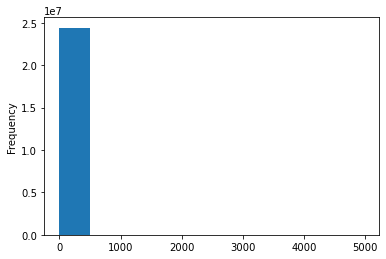

In [30]:
df['altitude'].plot.hist()

<AxesSubplot:ylabel='Frequency'>

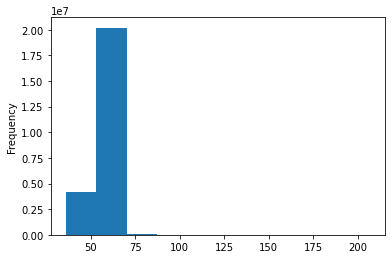

In [27]:
df['elevation'].plot.hist()

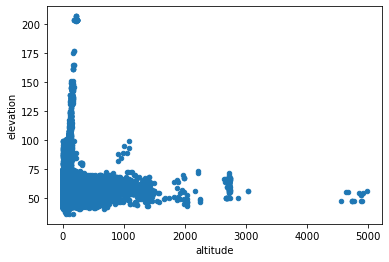

In [35]:
df[['altitude', 'elevation']].plot.scatter(x='altitude', y='elevation');

## Serial Preprocessing

Code below takes 30 mins to run for every `.csv` file in the `processed` dir. The approach is abandoned in favor of the `multiprocessing` approach above.

In [25]:
%%time
dir_ = '/mnt/processed/private/paturo/Geospatial/preprocessing/processed'
src_files = glob(dir_ + '/*.csv')

root = './raster_zip/'
with rasterio.open(root + 'footprints.tiff') as src:
    print(f'footprints crs: {src.crs}')
    for file in src_files[0:1]:
        temp = pd.read_csv(file)
        temp = filter_df(temp)
        temp_gdf = gpd.GeoDataFrame(temp, geometry=gpd.points_from_xy(temp.lon, temp.lat))
        temp_gdf.crs = "epsg:4326"
        
        # get elevation data
        temp_gdf['elevation'] = temp_gdf.apply(lambda row: get_value((row.geometry.x, row.geometry.y), src), axis=1)
        
        # get pixel count per building class
        temp_gdf = temp_gdf.to_crs(25393).apply(lambda x: get_building_counts(x, src, buffer=200), axis=1)
        display(temp_gdf.head())

footprints crs: EPSG:25393


,time,altitude,vehicle_speed,accel,decel,lon,lat,vehicle_id,osmid,lanes,...,dayofweek,month,residential,institutional,industrial,commercial,geometry,pix_business,pix_residential,pix_industrial
0,2021-02-22 02:58:42,75.0,41.0,0.0,2.0,121.762146,16.903545,123200872671,844417513,2.0,...,0,2,0,0,0,0,POINT (581043.909 1869764.170),0,400,140
1,2021-02-22 03:00:54,71.0,42.0,1.0,0.0,121.758650,16.891144,123200872671,245256452,2.0,...,0,2,0,0,0,0,POINT (580676.716 1868390.296),0,60,0
2,2021-02-22 04:13:45,62.0,28.0,1.0,0.0,121.770040,16.943373,123200872671,"[781677728, 836656295]",3.0,...,0,2,0,0,0,0,POINT (581867.715 1874175.280),260,275,0
3,2021-02-22 04:42:18,54.0,46.0,0.0,0.0,121.760796,16.898113,123200872671,245256452,2.0,...,0,2,0,0,0,0,POINT (580902.396 1869162.446),40,155,95
4,2021-02-22 04:50:26,57.0,19.0,1.0,1.0,121.767560,16.937610,123200872671,781677729,2.0,...,0,2,0,0,0,0,POINT (581606.033 1873536.444),622,280,0


CPU times: user 28min 42s, sys: 11.7 s, total: 28min 54s
Wall time: 29min 12s
